<a href="https://colab.research.google.com/github/abhinav-0075/Spam-SMS-Detection/blob/main/ML(Spam_Detec).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import joblib

In [ ]:
nltk.download('stopwords', quiet=True)

# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')

In [ ]:
# Keep only relevant columns and rename them
df = df.iloc[:, 0:2]
df.columns = ['label', 'message']

In [ ]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['label'].value_counts())


Dataset shape: (5572, 2)

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])


    # Apply stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    return text

In [ ]:
# Apply preprocessing
df['processed_message'] = df['message'].apply(preprocess_text)

# Convert labels to binary
df['label_binary'] = df['label'].map({'spam': 1, 'ham': 0})

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_message'],
    df['label_binary'],
    test_size=0.2,
    random_state=42
)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{model_name}.png')

    return accuracy, model


Training and evaluating Naive Bayes...

Naive Bayes Results:
Accuracy: 0.9686

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115


Training and evaluating Logistic Regression...

Logistic Regression Results:
Accuracy: 0.9498

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.65      0.78       150

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.95      1115


Training and evaluating Random Forest...

Random Forest Results:
Accuracy: 0.9776

Classification Report:
              pre

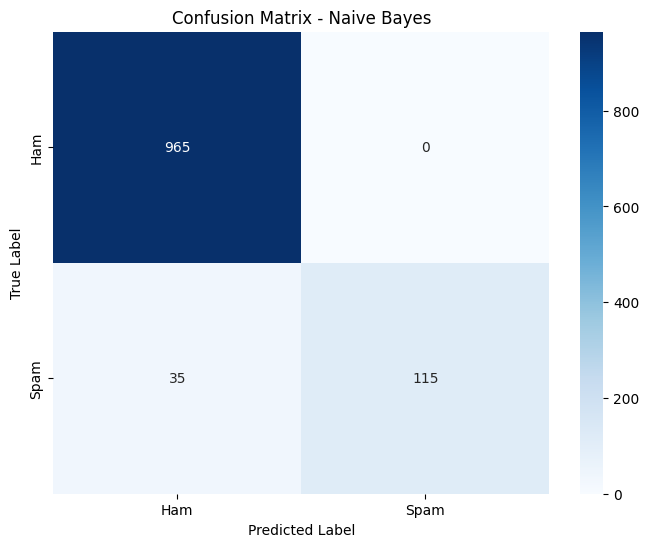

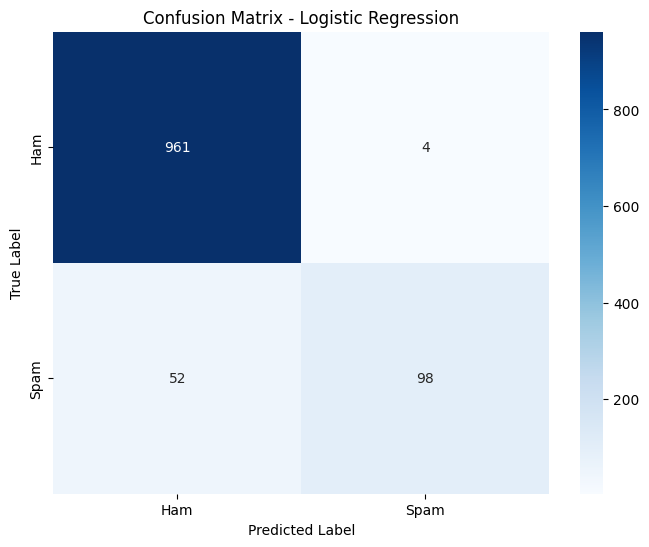

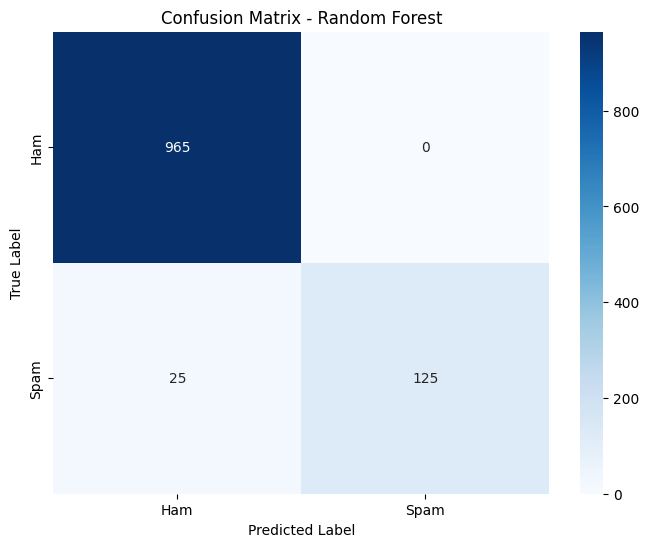

In [ ]:
# Train and evaluate all models
results = {}
for name, model in models.items():
    print(f"\nTraining and evaluating {name}...")
    accuracy, trained_model = evaluate_model(
        model, X_train_tfidf, X_test_tfidf, y_train, y_test, name
    )
    results[name] = (accuracy, trained_model)

# Find the best model
best_model_name = max(results, key=lambda k: results[k][0])
best_accuracy = results[best_model_name][0]
best_model = results[best_model_name][1]

print(f"\nBest performing model: {best_model_name} with accuracy: {best_accuracy:.4f}")


In [ ]:
# Save the best model
joblib.dump(best_model, 'spam_detection_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Function to predict on new messages
def predict_spam(new_messages):
    # Preprocess the new messages
    processed_messages = [preprocess_text(msg) for msg in new_messages]

    # Transform messages using TF-IDF
    X_new = tfidf_vectorizer.transform(processed_messages)

    # Make predictions
    predictions = best_model.predict(X_new)

    return predictions


Testing model on new messages:
Message: Congratulations! You've won a $1000 gift card. Call now to claim!
Prediction: SPAM

Message: Hey, can we meet tomorrow for the project discussion?
Prediction: HAM

Message: URGENT: Your account has been compromised. Click here now.
Prediction: HAM

Message: Don't forget to pick up milk on your way home.
Prediction: HAM

Analysis complete. Models trained and evaluated.


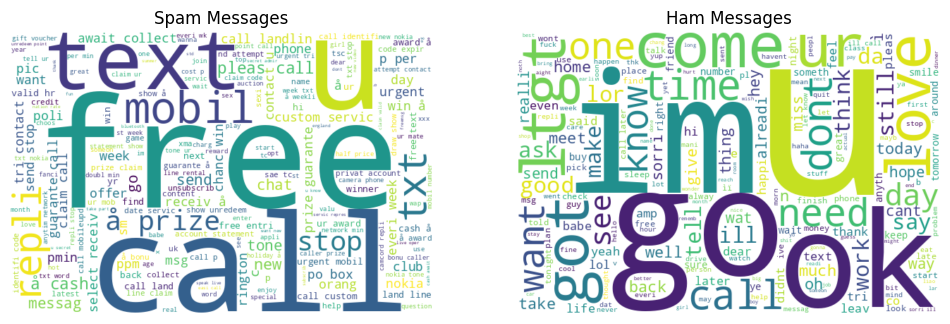

In [ ]:
# Test the model with example messages
test_messages = [
    "Congratulations! You've won a $1000 gift card. Call now to claim!",
    "Hey, can we meet tomorrow for the project discussion?",
    "URGENT: Your account has been compromised. Click here now.",
    "Don't forget to pick up milk on your way home."
]

print("\nTesting model on new messages:")
predictions = predict_spam(test_messages)
for msg, pred in zip(test_messages, predictions):
    pred_label = "SPAM" if pred == 1 else "HAM"
    print(f"Message: {msg}")
    print(f"Prediction: {pred_label}\n")

# Create a word cloud of spam and ham messages for visualization
from wordcloud import WordCloud
plt.figure(figsize=(12, 5))
# Spam word cloud
spam_texts = ' '.join(df[df['label'] == 'spam']['processed_message'])
wordcloud_spam = WordCloud(width=600, height=400, background_color='white').generate(spam_texts)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Spam Messages')
plt.axis('off')

# Ham word cloud
ham_texts = ' '.join(df[df['label'] == 'ham']['processed_message'])
wordcloud_ham = WordCloud(width=600, height=400, background_color='white').generate(ham_texts)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Ham Messages')
plt.axis('off')

plt.savefig('word_clouds.png')
print("Analysis complete. Models trained and evaluated.")